# Deep DMAE

This notebook is an example on how to use the tensorflow implementation of the Dissimilarity Mixture Autoencoder (DMAE).
We will show some examples on synthetic data using the deep model.

In [1]:
# Required libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("ggplot")
%matplotlib inline

# Path of the DMAE library
import sys
sys.path.append("../../")
import DMAE

# Setting random seed
np.random.seed(0)
tf.random.set_seed(0)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Imporing some helper functions to visualize and understand the results
import vis_utils

## Painwheel Data

We'll generate the Painwheel synthetic data that was used in: 

M. J. Johnson, D. K. Duvenaud, A. Wiltschko, R. P. Adams, and S. R. Datta, “Composing
368 graphical models with neural networks for structured representations and fast inference,” in
369 Advances in neural information processing systems, pp. 2946–2954, 2016.

In [2]:
def make_painwheel(rad_std, tan_std, n_groups, N, rate):
    """
    Generates the painwheel data, adapted from: https://github.com/mattjj/svae
    Arguments:
        rad_std: float
            Standard deviation for the angles.
        tan_std: float
            Tangential standard deviation.
        n_groups: int
            Number of groups to be generated.
        N: int
            Total number of samples.
        rate: float
            Controls the magnitude of the rotations.
        
    Returns:
        D: array-like, shape=(batch_size, n_clusters)
            Matrix of paiwise dissimilarities between the batch and the cluster's parameters.
    """
    np.random.seed(0)
    rads = np.linspace(0, 2*np.pi, n_groups, endpoint=False)
    samples = np.random.randn(N, 2)*np.array([rad_std, tan_std])
    samples[:,0] += 1
    labels = np.repeat(np.arange(n_groups), N//n_groups)

    angles = rads[labels]+rate*np.exp(samples[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return np.random.permutation(np.einsum('ti,tij->tj', samples, rotations))

Text(0.5, 1.0, 'Generated Data')

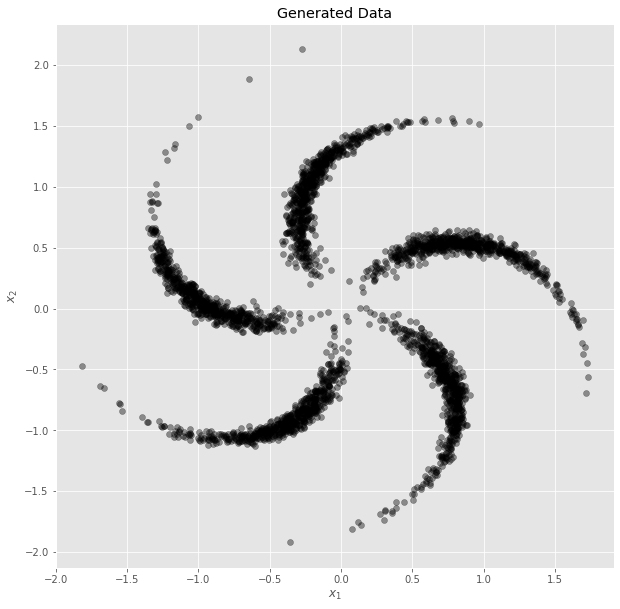

In [3]:
X = make_painwheel(0.3, 0.05, 5, 3200, 0.25)
# Visualizing the generated points
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], alpha=0.4, c="k")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

Now, we define some hyperparameters:

In [4]:
# Number of prototype vectors
n_clusters = 5
# Softmax inverse temperature parameter
alpha = 1000
# Pretrain parameters
batch_size = 256
pretrain_epochs = 100
pretrain_lr = 1e-3
# Cluster parameters
cluster_epochs = 80
cluster_lr = 1e-6
# Loss weights
lambda_r = 0.5
lambda_c = 1.0

We'll solve this problem using the Mahalanobis distance (includes the covariances):

In [5]:
dis = DMAE.Dissimilarities.mahalanobis
dmae_loss = DMAE.Losses.mahalanobis_loss
dis_name = "Mahalanobis"

In this case, a deep autoencoder will be used to transform the data. The final mixture density depends on the autoencoder's architecture. You can check this behavior with different activation functions:

In [6]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Dropdown(options=['sigmoid', "swish", "relu", "softplus", "elu", "selu"], value='sigmoid',
                          description='Activation:', disabled=False)
output = widgets.Output()
display(button, output)

act = "sigmoid"
def on_change(val):
    if val['type'] == 'change' and val['name'] == 'value':
        global act
        act = val["new"]
button.observe(on_change)

Dropdown(description='Activation:', options=('sigmoid', 'swish', 'relu', 'softplus', 'elu', 'selu'), value='si…

Output()

Defining the deep autoencoder:

In [7]:
print(f"Using activation [{act}]")
encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(32, activation=act, input_shape=(2,)),
                                      tf.keras.layers.Dense(32, activation=act),
                                      tf.keras.layers.Dense(5, activation="linear")])
decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(32, activation=act, input_shape=(5,)),
                                      tf.keras.layers.Dense(32, activation=act),
                                      tf.keras.layers.Dense(2, activation="linear")])
inp = tf.keras.layers.Input(shape=(2, ))
out = decoder(encoder(inp))
autoencoder = tf.keras.Model(inputs=inp, outputs=out)
autoencoder.compile(loss="mse", optimizer=tf.optimizers.Adam(lr=pretrain_lr))

Using activation [sigmoid]


Pretraining the autoencoder:

In [8]:
autoencoder.fit(X, X, epochs=pretrain_epochs)

Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 0.5810
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.5110
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.2620
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 12/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 13/100


Training a KMeans model with the transformed data to pretrain DMAE:

In [9]:
X_latent = encoder.predict(X)

In [10]:
pretrainer = KMeans(n_clusters=n_clusters).fit(X_latent)

Now, we can define a deep DMAE model:

In [11]:
inp = tf.keras.layers.Input(shape=(2, ))
h = encoder(inp)
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha, n_clusters,
                                                             initializers={"centers": DMAE.Initializers.InitKMeans(pretrainer),
                                                                           "cov": DMAE.Initializers.InitKMeansCov(pretrainer, X_latent, n_clusters),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             regularizers={"centers": tf.keras.regularizers.l2(0),
                                                                           "cov": tf.keras.regularizers.l2(0),
                                                                           "mixers": tf.keras.regularizers.l1(0)},
                                                             trainable = {"centers": True, "cov":True, "mixers":True},
                                                             dissimilarity=dis, grad_modifier=1)(h)
x_tilde = decoder(theta_tilde[0])
# defining keras model
full_model = tf.keras.Model(inputs=[inp], outputs=x_tilde)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Defining an auxiliar model to obtain the reconstruted parameters:

In [12]:
params_model = tf.keras.Model(inputs=inp, outputs=theta_tilde)

Adding the loss function and setting the optimizer:

In [12]:
loss1 = dmae_loss(h, *theta_tilde, alpha)
loss2 = tf.losses.mse(inp, x_tilde)
loss = lambda_c*loss1+lambda_r*loss2
full_model.add_loss(loss)
full_model.compile(optimizer=tf.optimizers.Adam(lr=cluster_lr))

Training the model:

In [14]:
hist = full_model.fit(X, epochs=cluster_epochs, batch_size=batch_size)

Epoch 1/80


/home/larajuse/Programs/anaconda3/envs/dmae/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


13/13 [==============================] - 0s 10ms/step - loss: 1187.4587
Epoch 2/80
13/13 [==============================] - 0s 8ms/step - loss: 1202.5038
Epoch 3/80
13/13 [==============================] - 0s 10ms/step - loss: 1193.6600
Epoch 4/80
13/13 [==============================] - 0s 10ms/step - loss: 1202.0660
Epoch 5/80
13/13 [==============================] - 0s 10ms/step - loss: 1198.7495
Epoch 6/80
13/13 [==============================] - 0s 8ms/step - loss: 1203.8873
Epoch 7/80
13/13 [==============================] - 0s 6ms/step - loss: 1197.3375
Epoch 8/80
13/13 [==============================] - 0s 8ms/step - loss: 1197.8530
Epoch 9/80
13/13 [==============================] - 0s 10ms/step - loss: 1188.2444
Epoch 10/80
13/13 [==============================] - 0s 7ms/step - loss: 1190.8695
Epoch 11/80
13/13 [==============================] - 0s 6ms/step - loss: 1189.6442
Epoch 12/80
13/13 [==============================] - 0s 8ms/step - loss: 1196.1837
Epoch 13/80
13/13 [

To visualize the results, we define an auxiliar model for the complete encoder:

In [15]:
inp = tf.keras.layers.Input(shape=(2,))
h = encoder(inp)
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(0.1, n_clusters=n_clusters,
                                                     dissimilarity=DMAE.Dissimilarities.mahalanobis,
                                                     trainable={"centers":False, "cov":False, "mixers":False})(h)
full_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
full_encoder.layers[-1].set_weights(full_model.layers[2].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let's see the Voronoi regions:

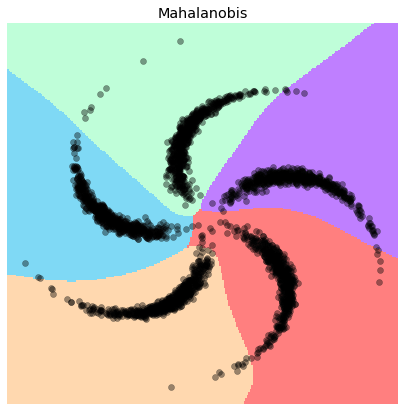

In [16]:
fig, ax = vis_utils.visualize_regions(full_encoder, dis_name, X, (7, 7), batch_size, show_clusters=False)

We can visualize the mixed distribution:

The posterior distributions:

(0.0, 1.0, 0.0, 1.0)

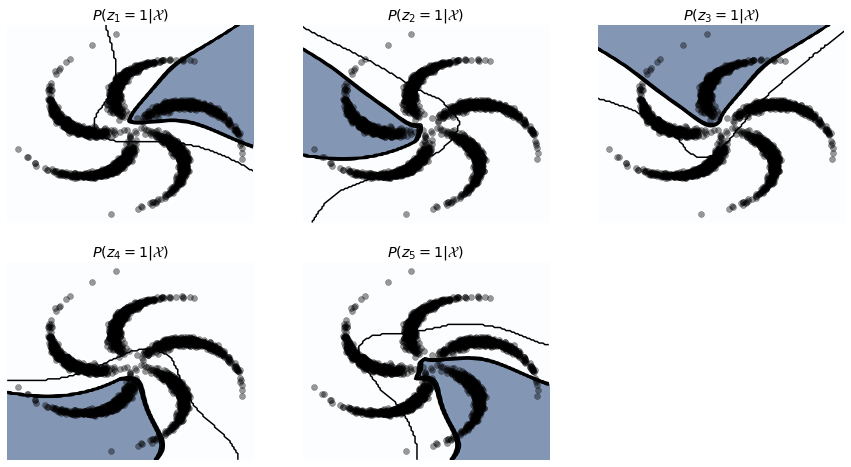

In [17]:
fig, ax = vis_utils.visualize_probas(full_encoder, X, n_clusters, rows=2, cols=3, figsize=(15, 8))
ax[1, 2].axis("off")

## Circles Data

Now, we'll generate two-dimensional circles data.

Text(0.5, 1.0, 'Generated Data')

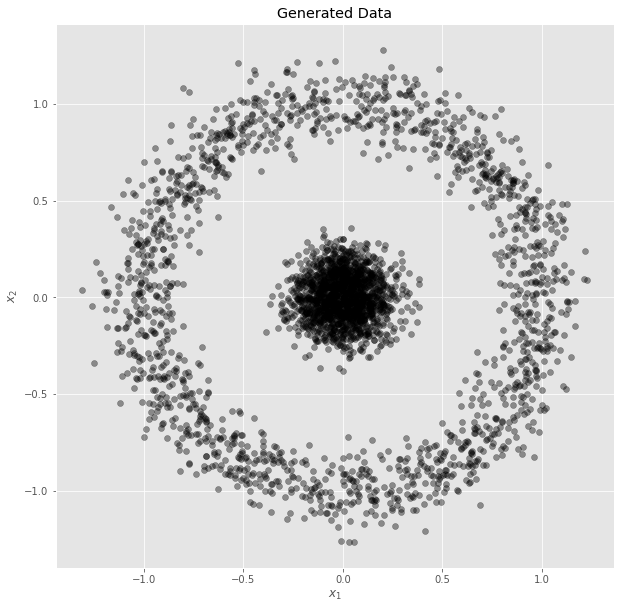

In [18]:
X, _ = make_circles(3200, noise=0.1, factor=0.1)
# Visualizing the generated points
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c="k", alpha=0.4)
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

Clustering this problem is not an easy task and requires an appropriate definition and initialization of the autoencoder architecture. 

Instead of dealing with this issue, we're going to pretrain the autoencoder using random Fourier features to make the autoencoder an approximation of a RBF kernel. Let us define the hyperparameters:

In [19]:
# Number of prototype vectors
n_clusters = 2
# Softmax inverse temperature parameter
alpha = 1000
# Pretrain parameters
batch_size = 32
pretrain_epochs = 100
pretrain_lr = 1e-3
# Cluster parameters
cluster_epochs = 80
cluster_lr = 1e-5
# Loss weights
lambda_r = 0.5
lambda_c = 1.0
# Random fourier features parameters
gamma = 10
n_components = 100

Extracting the random Fourier features:

In [20]:
from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=gamma, random_state=1, n_components=n_components)
X_features = rbf_feature.fit_transform(X)

Please choose an activation function:

In [21]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Dropdown(options=['sigmoid', "tanh", "relu", "linear"], value='sigmoid',
                          description='Activation:', disabled=False)
output = widgets.Output()
display(button, output)

act = "sigmoid"
def on_change(val):
    if val['type'] == 'change' and val['name'] == 'value':
        global act
        act = val["new"]
button.observe(on_change)

Dropdown(description='Activation:', options=('sigmoid', 'tanh', 'relu', 'linear'), value='sigmoid')

Output()

Defining the deep autoencoder architecture:

In [22]:
encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation=act, input_shape=(2,)),
                                      tf.keras.layers.Dense(256, activation=act),
                                      tf.keras.layers.Dense(n_components, activation="linear")])
decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation=act, input_shape=(n_components,)),
                                      tf.keras.layers.Dense(256, activation=act),
                                      tf.keras.layers.Dense(2, activation="linear")])
inp = tf.keras.layers.Input(shape=(2, ))
out = decoder(encoder(inp))
autoencoder = tf.keras.Model(inputs=inp, outputs=out)

We'll solve this problem using the Mahalanobis distance (includes the covariances):

In [23]:
dis = DMAE.Dissimilarities.mahalanobis
dmae_loss = DMAE.Losses.mahalanobis_loss
dis_name = "Mahalanobis"

First, we'll pretrain the encoder to learn the features:

In [24]:
encoder.compile(loss="mse", optimizer=tf.optimizers.Adam(lr=pretrain_lr))
encoder.fit(X, X_features, epochs=pretrain_epochs)

Epoch 1/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0079
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0072
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 10/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0070A: 0s - loss:
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 12/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0069


Second, we'll pretrain the decoder using the learned encoder features:

In [25]:
autoencoder.layers[1].trainable=False
autoencoder.compile(loss="mse", optimizer=tf.optimizers.Adam(lr=pretrain_lr))
autoencoder.fit(X, X, epochs=pretrain_epochs)
autoencoder.layers[1].trainable=True

Epoch 1/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2255
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 4/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0035
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 8.9903e-04
Epoch 8/100
100/100 [==============================] - 0s 5ms/step - loss: 6.2506e-04
Epoch 9/100
100/100 [==============================] - 1s 5ms/step - loss: 5.0880e-04
Epoch 10/100
100/100 [==============================] - 1s 5ms/step - loss: 3.9987e-04
Epoch 11/100
100/100 [==============================] - 0s 4ms/step - loss: 3.5561e-04
Epoch 12/100
100/100 [==============================] - 0s 3ms/step - loss: 

Training a KMeans model with the transformed data to pretrain DMAE:

In [26]:
X_latent = encoder.predict(X)

In [27]:
pretrainer = KMeans(n_clusters=n_clusters).fit(X_latent)

Now, we can define a deep DMAE model:

In [28]:
preds = pretrainer.predict(X_latent)

In [29]:
inp = tf.keras.layers.Input(shape=(2, ))
h = encoder(inp)
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha, n_clusters,
                                                             initializers={"centers": DMAE.Initializers.InitKMeans(pretrainer),
                                                                           "cov": DMAE.Initializers.InitIdentityCov(X_latent, n_clusters),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             trainable = {"centers": True, "cov":True, "mixers":True},
                                                             dissimilarity=DMAE.Dissimilarities.mahalanobis, grad_modifier=1)(h)
x_tilde = decoder(theta_tilde[0])
# defining keras model
full_model = tf.keras.Model(inputs=[inp], outputs=x_tilde)

Defining an auxiliar model to obtain the reconstruted parameters:

In [30]:
params_model = tf.keras.Model(inputs=inp, outputs=theta_tilde)

Adding the loss function and setting the optimizer:

In [32]:
loss1 = DMAE.Losses.mahalanobis_loss(h, *theta_tilde, alpha)
loss2 = tf.losses.mse(inp, x_tilde)
loss = lambda_c*loss1+lambda_r*loss2
full_model.add_loss(loss)
full_model.compile(optimizer=tf.optimizers.Adam(lr=cluster_lr))

Training the model:

In [33]:
hist = full_model.fit(X, epochs=cluster_epochs)

Epoch 1/80
100/100 [==============================] - 1s 10ms/step - loss: 17.2849
Epoch 2/80
100/100 [==============================] - 1s 10ms/step - loss: 15.6400
Epoch 3/80
100/100 [==============================] - 1s 11ms/step - loss: 14.3362
Epoch 4/80
100/100 [==============================] - 1s 11ms/step - loss: 13.2881
Epoch 5/80
100/100 [==============================] - 1s 10ms/step - loss: 12.3778
Epoch 6/80
100/100 [==============================] - 1s 10ms/step - loss: 11.5762
Epoch 7/80
100/100 [==============================] - 1s 13ms/step - loss: 10.8668
Epoch 8/80
100/100 [==============================] - 1s 12ms/step - loss: 10.2305
Epoch 9/80
100/100 [==============================] - 1s 11ms/step - loss: 9.6564
Epoch 10/80
100/100 [==============================] - 1s 11ms/step - loss: 9.1473
Epoch 11/80
100/100 [==============================] - 1s 11ms/step - loss: 8.6859
Epoch 12/80
100/100 [==============================] - 1s 10ms/step - loss: 8.2618
Epoch

To visualize the results, we define an auxiliar model for the complete encoder:

In [34]:
inp = tf.keras.layers.Input(shape=(2,))
h = encoder(inp)
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(5, n_clusters=n_clusters,
                                                     dissimilarity=DMAE.Dissimilarities.mahalanobis,
                                                     trainable={"centers":False, "cov":False, "mixers":False})(h)
full_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
full_encoder.layers[-1].set_weights(full_model.layers[2].get_weights())

Let's see the Voronoi regions:

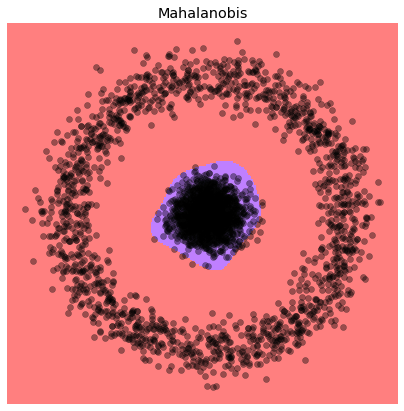

In [35]:
fig, ax = vis_utils.visualize_regions(full_encoder, dis_name, X, (7, 7), batch_size, show_clusters=False)

The posterior distributions:

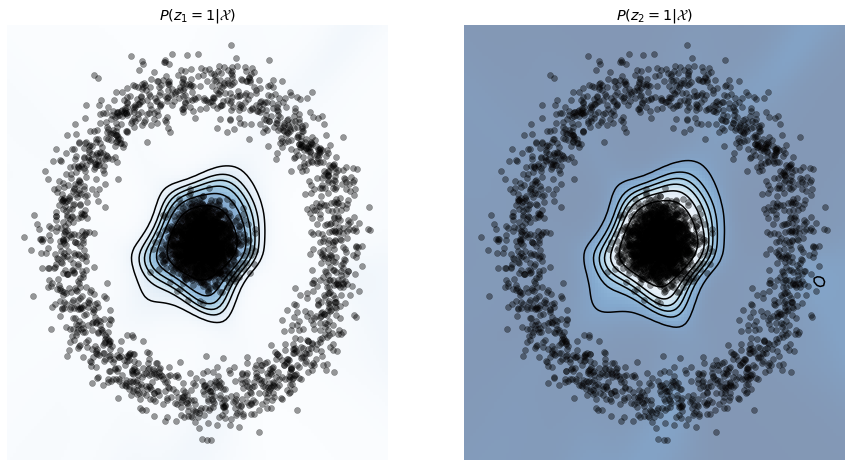

In [36]:
fig, ax = vis_utils.visualize_probas(full_encoder, X, n_clusters, rows=1, cols=2, figsize=(15, 8))